# HMER Decoder Comparison Notebook
This notebook will load data, train LSTM & Transformer decoders, and compute BLEU scores.

# 1. Install and Imports

In [1]:
!pip install datasets nltk pillow torchvision matplotlib

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torchvision import models, transforms
from datasets import load_dataset
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
import matplotlib.pyplot as plt
import numpy as np

/Users/aryanshelke/Documents/GitHub/math_to_latex/src/decoders_robustness/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# 2. Load Dataset (Small Subset)

In [2]:
# Load dataset
ds = load_dataset("deepcopy/MathWriting-Human")

train_raw = ds["train"]
val_raw = ds["val"]
test_raw = ds["test"]

# Small debugging subsets
N_train = 200
N_val = 50
N_test = 50

train_raw = train_raw.select(range(N_train))
val_raw = val_raw.select(range(N_val))
test_raw = test_raw.select(range(N_test))

train_raw, val_raw, test_raw


(Dataset({
     features: ['image', 'latex', 'sample_id', 'split_tag', 'data_type'],
     num_rows: 200
 }),
 Dataset({
     features: ['image', 'latex', 'sample_id', 'split_tag', 'data_type'],
     num_rows: 50
 }),
 Dataset({
     features: ['image', 'latex', 'sample_id', 'split_tag', 'data_type'],
     num_rows: 50
 }))

# 3. Preprocessing + Tokenizer

In [3]:
transform = transforms.Compose([
    transforms.Resize((320, 640)),
    transforms.ToTensor(),
])

# Build small char-level vocab
chars = set()
for ex in train_raw["latex"]:
    chars.update(list(ex))
chars = sorted(list(chars))

stoi = {c: i+1 for i, c in enumerate(chars)}
itos = {i: c for c, i in stoi.items()}
vocab_size = len(stoi) + 1  # pad = 0

def tokenize(text, max_len=120):
    ids = [stoi.get(c, 0) for c in text[:max_len]]
    ids = ids + [0]*(max_len - len(ids))
    return torch.tensor(ids)

class MathDataset(Dataset):
    def __init__(self, hf):
        self.hf = hf
    def __len__(self):
        return len(self.hf)
    def __getitem__(self, idx):
        item = self.hf[idx]
        img = transform(item["image"].convert("RGB"))
        tgt = tokenize(item["latex"])
        return img, tgt

train_ds = MathDataset(train_raw)
val_ds = MathDataset(val_raw)
test_ds = MathDataset(test_raw)

train_loader = DataLoader(train_ds, batch_size=16, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=16)
test_loader = DataLoader(test_ds, batch_size=1)


# 4. Encoder (ResNet-50)

In [4]:
class ResNet50Encoder(nn.Module):
    def __init__(self, hidden_dim=512):
        super().__init__()
        m = models.resnet50(weights='DEFAULT')
        self.backbone = nn.Sequential(*list(m.children())[:-2])
        self.proj = nn.Linear(2048, hidden_dim)  # project to match decoder

    def forward(self, x):
        x = self.backbone(x)  # B, 2048, H/32, W/32
        B,C,H,W = x.size()
        x = x.view(B,C,H*W).permute(0,2,1)  # B, L, C
        x = self.proj(x)  # B, L, hidden_dim
        return x


# 5. LSTM Decoder

In [5]:
class LSTMDecoder(nn.Module):
    def __init__(self, vocab_size, hidden=512):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, hidden)
        self.lstm = nn.LSTM(hidden, hidden, batch_first=True)
        self.fc = nn.Linear(hidden, vocab_size)

    def forward(self, features, tgt):
        emb = self.embed(tgt)
        out, _ = self.lstm(emb)
        return self.fc(out)


# 6. Transformer Decoder

In [6]:
class TransformerDecoder(nn.Module):
    def __init__(self, vocab_size, hidden=512, n_heads=8, depth=4):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, hidden)
        layer = nn.TransformerDecoderLayer(
            d_model=hidden, nhead=n_heads, batch_first=True
        )
        self.decoder = nn.TransformerDecoder(layer, num_layers=depth)
        self.fc = nn.Linear(hidden, vocab_size)

    def forward(self, features, tgt):
        tgt_emb = self.embed(tgt)
        out = self.decoder(tgt_emb, features)
        return self.fc(out)


# 7. Training Utilities

In [7]:
def train_one_epoch(model, encoder, loader, optimizer, criterion, device):
    model.train(); encoder.train()
    total_loss = 0

    for img, tgt in loader:
        img, tgt = img.to(device), tgt.to(device)
        optimizer.zero_grad()

        feats = encoder(img)
        outputs = model(feats, tgt[:, :-1])
        loss = criterion(outputs.reshape(-1, vocab_size), tgt[:, 1:].reshape(-1))
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(loader)


# 8. BLEU Evaluation

In [8]:
def evaluate_bleu(model, encoder, loader, device):
    model.eval(); encoder.eval()
    smoothie = SmoothingFunction().method4
    scores = []

    for img, tgt in loader:
        img = img.to(device)
        feats = encoder(img)

        # greedy decoding
        dec = torch.zeros((1, 120), dtype=torch.long).to(device)
        for i in range(119):
            out = model(feats, dec)
            next_token = out[0, i].argmax()
            dec[0, i+1] = next_token

        pred = "".join([itos.get(tok.item(), "") for tok in dec[0]])
        gt = "".join([itos.get(tok.item(), "") for tok in tgt[0]])

        bleu = sentence_bleu([list(gt)], list(pred), smoothing_function=smoothie)
        scores.append(bleu)

    return np.mean(scores)


# 9. Train Both Decoders

In [9]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

# Shared encoder for both models
encoder_lstm = ResNet50Encoder().to(device)
encoder_trans = ResNet50Encoder().to(device)

lstm = LSTMDecoder(vocab_size).to(device)
trans = TransformerDecoder(vocab_size).to(device)

criterion = nn.CrossEntropyLoss(ignore_index=0)

opt_lstm = torch.optim.Adam(
    list(encoder_lstm.parameters()) + list(lstm.parameters()), lr=1e-4
)
opt_trans = torch.optim.Adam(
    list(encoder_trans.parameters()) + list(trans.parameters()), lr=1e-4
)

EPOCHS = 10  # keep it short

# Store losses
train_losses_lstm, val_losses_lstm = [], []
train_losses_trans, val_losses_trans = [], []


# -----------------------------
# Helper function for val loss
# -----------------------------
def compute_val_loss(encoder, decoder, loader, criterion, device):
    encoder.eval()
    decoder.eval()
    total_loss = 0

    with torch.no_grad():
        for img, tgt in loader:
            img, tgt = img.to(device), tgt.to(device)

            feats = encoder(img)
            outputs = decoder(feats, tgt[:, :-1])
            loss = criterion(
                outputs.reshape(-1, vocab_size),
                tgt[:, 1:].reshape(-1)
            )
            total_loss += loss.item()

    encoder.train()
    decoder.train()
    return total_loss / len(loader)



# -----------------------------
# TRAIN LSTM
# -----------------------------
print("Training LSTM...")
for epoch in range(EPOCHS):
    train_loss = train_one_epoch(
        lstm, encoder_lstm, train_loader, opt_lstm, criterion, device
    )
    val_loss = compute_val_loss(
        encoder_lstm, lstm, val_loader, criterion, device
    )

    train_losses_lstm.append(train_loss)
    val_losses_lstm.append(val_loss)

    print(f"LSTM Epoch {epoch+1}: train={train_loss:.4f}, val={val_loss:.4f}")


# -----------------------------
# TRAIN TRANSFORMER
# -----------------------------
print("\nTraining Transformer...")
for epoch in range(EPOCHS):
    train_loss = train_one_epoch(
        trans, encoder_trans, train_loader, opt_trans, criterion, device
    )
    val_loss = compute_val_loss(
        encoder_trans, trans, val_loader, criterion, device
    )

    train_losses_trans.append(train_loss)
    val_losses_trans.append(val_loss)

    print(f"Transformer Epoch {epoch+1}: train={train_loss:.4f}, val={val_loss:.4f}")


Device: cpu
Training LSTM...
LSTM Epoch 1: train=4.3327, val=4.2034
LSTM Epoch 2: train=4.0366, val=3.8894
LSTM Epoch 3: train=3.6479, val=3.4217
LSTM Epoch 4: train=3.2286, val=3.1165
LSTM Epoch 5: train=2.9700, val=2.8963
LSTM Epoch 6: train=2.7953, val=2.7260
LSTM Epoch 7: train=2.6207, val=2.5897
LSTM Epoch 8: train=2.4781, val=2.4904
LSTM Epoch 9: train=2.3809, val=2.4016
LSTM Epoch 10: train=2.2916, val=2.3296

Training Transformer...
Transformer Epoch 1: train=3.5977, val=3.1318
Transformer Epoch 2: train=2.8348, val=2.7272
Transformer Epoch 3: train=2.5313, val=2.5442
Transformer Epoch 4: train=2.3186, val=2.4043
Transformer Epoch 5: train=2.1148, val=2.2545
Transformer Epoch 6: train=1.9243, val=2.1770
Transformer Epoch 7: train=1.7637, val=2.1017
Transformer Epoch 8: train=1.6302, val=2.0434
Transformer Epoch 9: train=1.4789, val=2.0439
Transformer Epoch 10: train=1.3967, val=2.0034


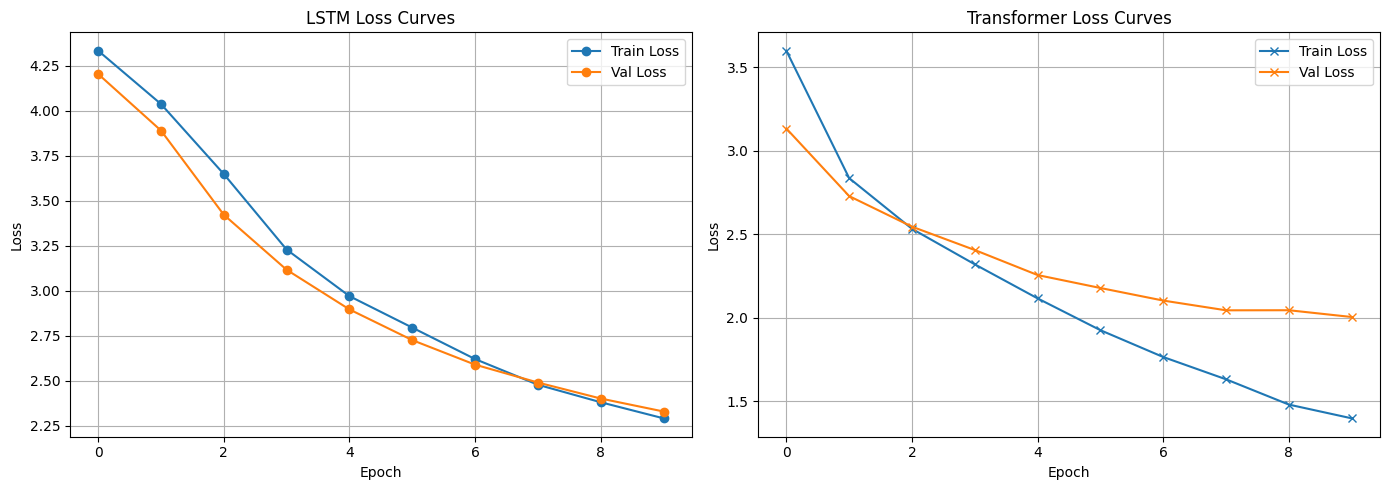

In [10]:
# Side-by-side plots for LSTM and Transformer
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# --- LSTM Plot ---
axes[0].plot(train_losses_lstm, label='Train Loss', marker='o')
axes[0].plot(val_losses_lstm, label='Val Loss', marker='o')
axes[0].set_title('LSTM Loss Curves')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].grid(True)

# --- Transformer Plot ---
axes[1].plot(train_losses_trans, label='Train Loss', marker='x')
axes[1].plot(val_losses_trans, label='Val Loss', marker='x')
axes[1].set_title('Transformer Loss Curves')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()


Running rotation robustness (this may take a minute for each angle on CPU)...
Angle   0° -> LSTM BLEU: 0.0272, Transformer BLEU: 0.0040
Angle   5° -> LSTM BLEU: 0.0272, Transformer BLEU: 0.0041
Angle  -5° -> LSTM BLEU: 0.0272, Transformer BLEU: 0.0032
Angle  10° -> LSTM BLEU: 0.0272, Transformer BLEU: 0.0038
Angle -10° -> LSTM BLEU: 0.0272, Transformer BLEU: 0.0034
Angle  20° -> LSTM BLEU: 0.0272, Transformer BLEU: 0.0033
Angle -20° -> LSTM BLEU: 0.0272, Transformer BLEU: 0.0038


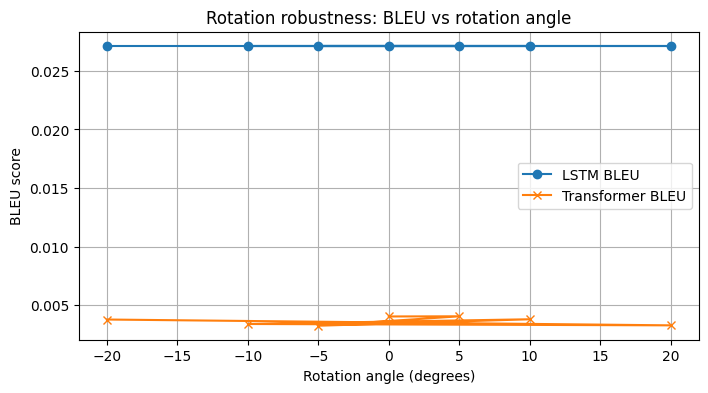

In [11]:
# ---------------------------
# ROBUSTNESS: Rotation sweep + BLEU
# ---------------------------
import torchvision.transforms.functional as TF
import numpy as np
import matplotlib.pyplot as plt
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

smooth = SmoothingFunction().method4
max_len = 128

# Greedy decode function for either decoder (works with current decoder APIs)
def greedy_decode(decoder, encoder, img_tensor, sos_token=0, eos_token=None, max_len=max_len):
    """
    img_tensor: (C,H,W) or (1,C,H,W) -> expects unbatched image tensor
    returns list of token ids (length max_len)
    """
    device = next(decoder.parameters()).device
    decoder.eval(); encoder.eval()
    with torch.no_grad():
        img = img_tensor.unsqueeze(0).to(device) if img_tensor.ndim==3 else img_tensor.to(device)
        feats = encoder(img)  # B=1, L, hidden
        # start sequence: we assume model uses index 0 for PAD; no explicit <sos> used in minimal tokenizer
        seq = torch.zeros((1, max_len), dtype=torch.long).to(device)
        for t in range(max_len-1):
            out = decoder(feats, seq)              # (1, max_len, V)
            next_tok = out[0, t].argmax().unsqueeze(0)
            seq[0, t+1] = next_tok
            # optional stop if eos_token provided:
            if eos_token is not None and next_tok.item() == eos_token:
                break
        return seq[0].cpu().tolist()

# Function to compute BLEU for a decoder at one rotation angle
def bleu_on_rotated_set(decoder, encoder, test_loader, angle):
    scores = []
    for img, tgt in test_loader:
        # img: (B=1,C,H,W) or (B,C,H,W). We will rotate per-sample.
        # handle batch size >1
        for i in range(img.size(0)):
            img_i = img[i]  # (C,H,W)
            # rotate. fill=0 keeps background consistent (image is normalized; fill ~0)
            img_rot = TF.rotate(img_i, angle=angle, expand=False, fill=0)
            pred_ids = greedy_decode(decoder, encoder, img_rot)
            # convert ids -> chars using itos (dict mapping)
            pred_str = "".join([itos.get(int(tok), "") for tok in pred_ids]).strip()
            tgt_ids = tgt[i].cpu().tolist()
            tgt_str = "".join([itos.get(int(tok), "") for tok in tgt_ids]).strip()
            # BLEU on token-level (character-level here)
            try:
                score = sentence_bleu([list(tgt_str)], list(pred_str), smoothing_function=smooth)
            except Exception:
                score = 0.0
            scores.append(score)
    return float(np.mean(scores)) if scores else 0.0

# Angles to test
angles = [0, 5, -5, 10, -10, 20, -20]

# Evaluate both decoders
bleu_lstm_by_angle = []
bleu_trans_by_angle = []

print("Running rotation robustness (this may take a minute for each angle on CPU)...")
for a in angles:
    b_l = bleu_on_rotated_set(lstm, encoder_lstm, test_loader, a)
    b_t = bleu_on_rotated_set(trans, encoder_trans, test_loader, a)
    bleu_lstm_by_angle.append(b_l)
    bleu_trans_by_angle.append(b_t)
    print(f"Angle {a:>3}° -> LSTM BLEU: {b_l:.4f}, Transformer BLEU: {b_t:.4f}")

# Plot results
plt.figure(figsize=(8,4))
plt.plot(angles, bleu_lstm_by_angle, label="LSTM BLEU", marker='o')
plt.plot(angles, bleu_trans_by_angle, label="Transformer BLEU", marker='x')
plt.xlabel("Rotation angle (degrees)")
plt.ylabel("BLEU score")
plt.title("Rotation robustness: BLEU vs rotation angle")
plt.grid(True)
plt.legend()
plt.show()


# 10. Compare BLEU Scores

In [12]:
print("Evaluating BLEU scores...")

bleu_lstm = evaluate_bleu(lstm, encoder_lstm, test_loader, device)
bleu_trans = evaluate_bleu(trans, encoder_trans, test_loader, device)

print("\n=== BLEU Score Comparison ===")
print(f"LSTM BLEU Score:        {bleu_lstm:.4f}")
print(f"Transformer BLEU Score: {bleu_trans:.4f}")

if bleu_lstm > bleu_trans:
    print("\n👉 LSTM Decoder is Superior on This Small Subset")
else:
    print("\n👉 Transformer Decoder is Superior on This Small Subset")


Evaluating BLEU scores...

=== BLEU Score Comparison ===
LSTM BLEU Score:        0.0289
Transformer BLEU Score: 0.0042

👉 LSTM Decoder is Superior on This Small Subset
